In [6]:
import os 
import xarray as xr
import numpy as np
import glob
import pandas as pd
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, normalize
import itertools
from numpy.lib.stride_tricks import sliding_window_view
import datetime
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter)


In [7]:
project_dir = '/Users/huripari/Documents/PhD/TCs_Genesis'
data_dir = os.path.join(project_dir, 'data')

var = 'msl'
basin = 'GLB'
n_clusters = 18
norm = False
seasonal_soothing = False
train_yearI, train_yearF = 1980, 2014
test_yearI, test_yearF = 2014, 2021
res = 2.5
resolution = f'{res}x{res}'
path_predictor = os.path.join(data_dir, 'ERA5', resolution, 'MSLP-SST', 'ERA5_MSLP-SST')


In [8]:
# Data extraction from .nc files
for y, year in enumerate(range(train_yearI, train_yearF+1)):
    path = path_predictor + f'_{resolution}_{year}.nc'
    if y == 0:
        train_data = xr.open_dataset(path)[var]
    else:
        train_data = xr.concat([train_data, xr.open_dataset(path)[var]], dim='time')
for y, year in enumerate(range(test_yearI, test_yearF+1)):
    path = path_predictor + f'_{resolution}_{year}.nc'
    if y == 0:
        test_data = xr.open_dataset(path)[var]
    else:
        test_data = xr.concat([test_data, xr.open_dataset(path)[var]], dim='time')
total_data = xr.concat([train_data, test_data], dim='time')

In [9]:
# Reshape the data -> (time, lat, lon) -> (lat*lon, time)
data = train_data.values
data_res = data.reshape(data.shape[0], data.shape[1]*data.shape[2]).T

# Mask the data if there are missing values or if the in a sub-basin
if basin == 'GLB':
    data_res_masked = data_res
else:
    a = 0
    ## NEED TO COMPUTE EVENTUAL MASKING ##
# Normalize each time series
if norm==True:
    data_res_masked = normalize(data_res_masked, axis=1, copy=True, return_norm=False)

In [10]:
# Perform clustering
from clustering import cluster_model
cluster = cluster_model(data_res_masked, n_clusters, var)
cluster.check_data()
cluster.kmeans()

Data is a 2D numpy array
Please, be sure the data is in the correct format: (n_samples (nodes), n_features (variables (time))


In [11]:
# Get the closest node to the cluster center
centroids = cluster_model.get_closest2center2(cluster, data_res_masked)
# Get the data for the centroids 
latitudes = train_data.latitude.values
longitudes = train_data.longitude.values
iter = itertools.product(latitudes, longitudes)
nodes_list = np.array(list(iter))

lons_c = [np.array(nodes_list)[centroids][i][1] for i in range(len(np.array(nodes_list)[centroids]))]
lats_c = [np.array(nodes_list)[centroids][i][0] for i in range(len(np.array(nodes_list)[centroids]))]

Index of the closest cluster center for each sample [3441, 3786, 1821, 2576, 804, 3962, 1106, 2938, 1793, 922, 1017, 1359, 3255, 695, 4331, 799, 295, 4204]


Index of the closest cluster center for each sample [3441, 3786, 1821, 2576, 804, 3962, 1106, 2938, 1793, 922, 1017, 1359, 3255, 695, 4331, 799, 295, 4204]


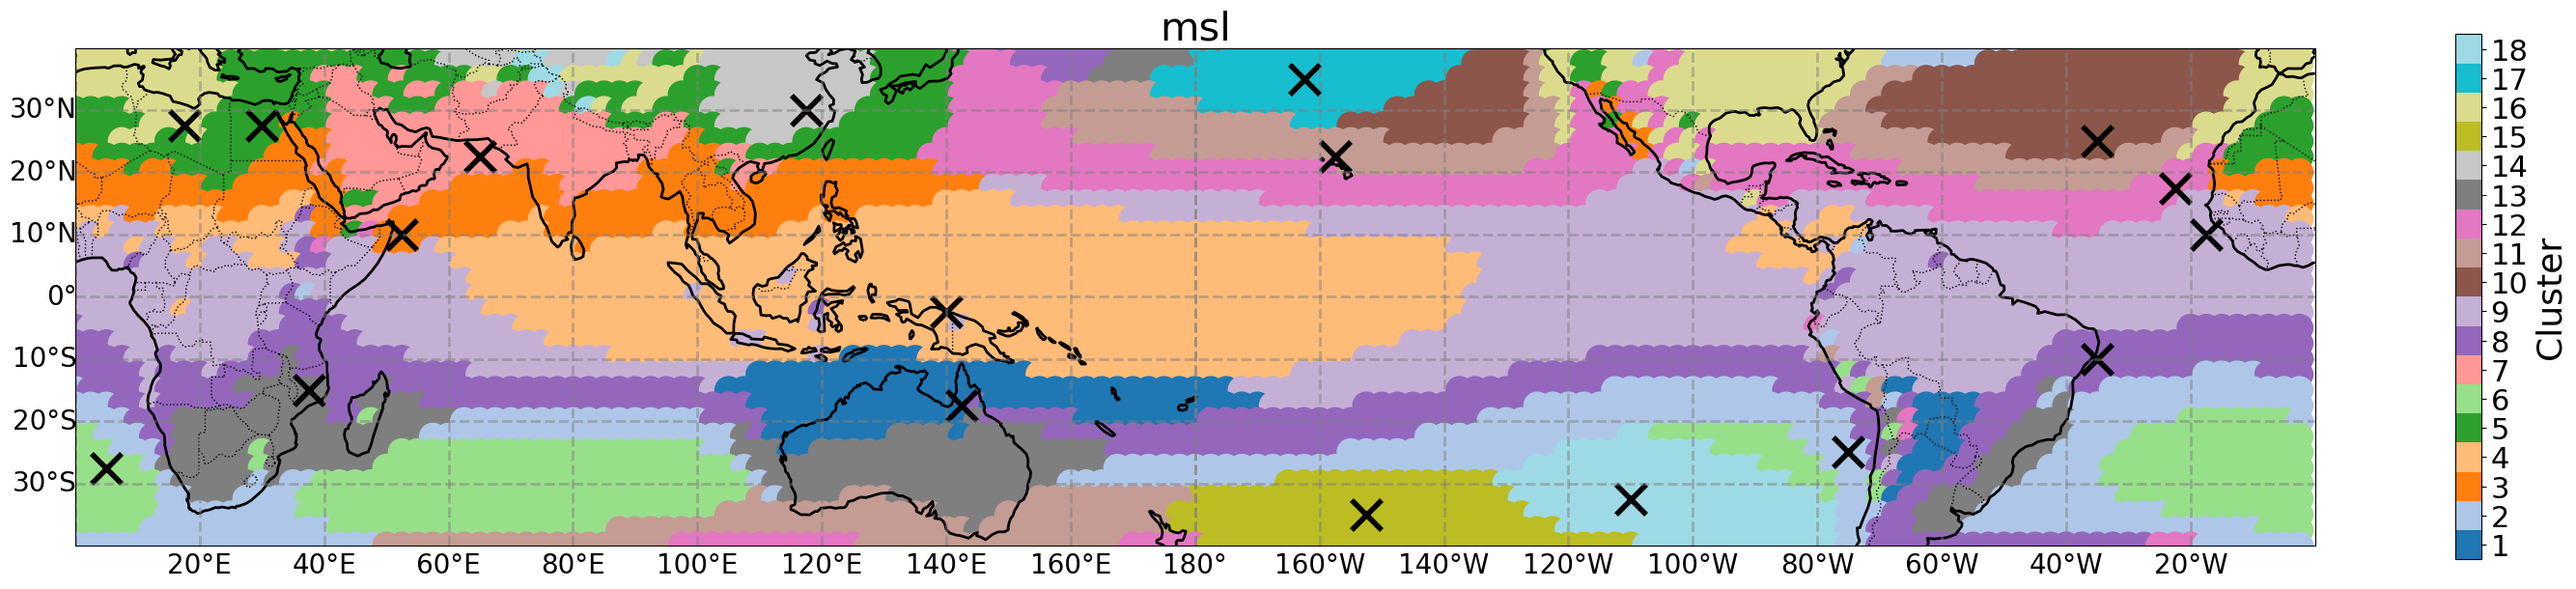

In [12]:
mask = None
cluster_model.plot_clusters(cluster, data_res_masked, latitudes, longitudes, mask)